# Train MLP to Predict OPS
This notebook trains a simple MLP on player stat data.

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
# Load and preprocess data
df = pd.read_csv('../data/processed_player_data.csv')

# Save player names temporarily for future use (optional)
player_names = df.get('Name', pd.Series(np.arange(len(df))))  # Use index if Name not found

# Define features and target
features = df.columns.difference(['OPS_target']).tolist()
target = 'OPS_target'

# Normalize features
X = df[features].fillna(0).values
y = df[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X_scaled, y, player_names, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [ ]:
class PlayerMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

model = PlayerMLP(X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# train
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}")


Epoch 0: Train Loss = 0.7554
Epoch 10: Train Loss = 0.3110
Epoch 20: Train Loss = 0.0908
Epoch 30: Train Loss = 0.0661
Epoch 40: Train Loss = 0.0348
Epoch 50: Train Loss = 0.0252
Epoch 60: Train Loss = 0.0186
Epoch 70: Train Loss = 0.0141
Epoch 80: Train Loss = 0.0113
Epoch 90: Train Loss = 0.0092


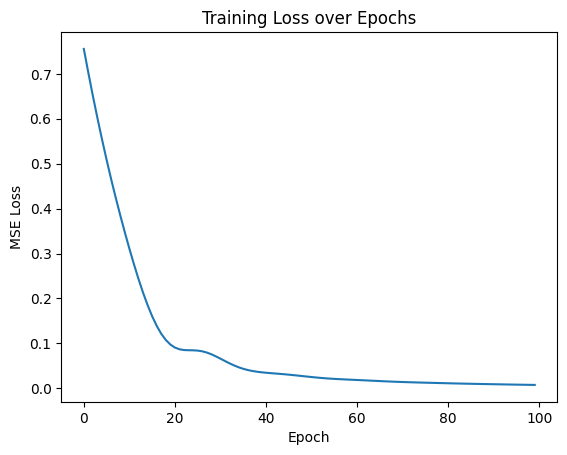

In [ ]:
# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


In [13]:
# 🔍 Evaluate model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
    y_true = y_test.numpy().flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.1780
RMSE: 0.2233


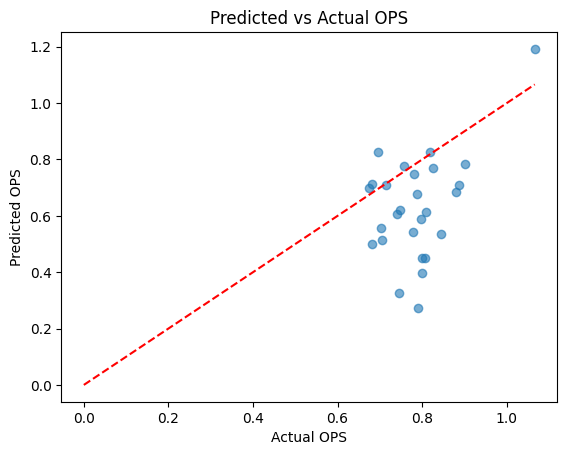

In [ ]:
# Plot predicted vs actual
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')
plt.xlabel("Actual OPS")
plt.ylabel("Predicted OPS")
plt.title("Predicted vs Actual OPS")
plt.show()
